In [1]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.utils import plot_model

In [25]:
DATASET = "yelp_polarity_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 64
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000
NUM_EPOCHS = 5
VALIDATION_STEPS = 30

In [3]:
dataset, info = tfds.load(DATASET, with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteU7H4HQ/yelp_polarity_reviews-train.tfrecord


  0%|          | 0/560000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteU7H4HQ/yelp_polarity_reviews-test.tfrecord


  0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('type data: ', type(example))
  print('label: ', label.numpy())

text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

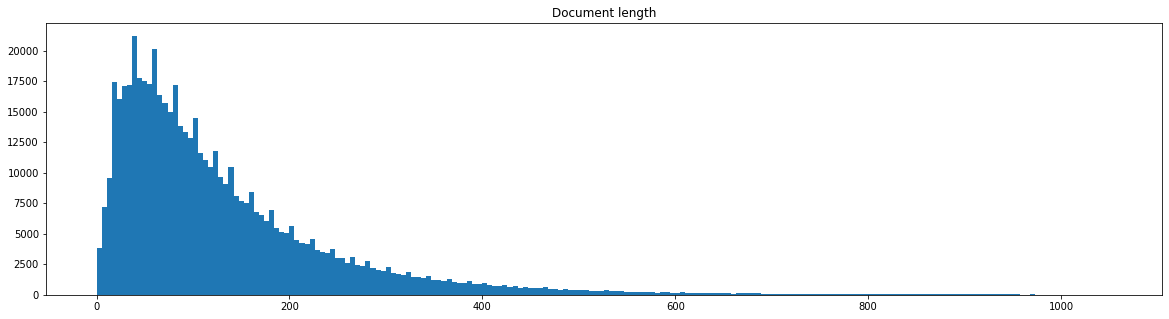

Text informations:
 - number of seq:  560000
 - max length:     1052
 - min length:     1
 - mean length:    133.0288732142857


In [5]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - number of seq:  {len(num_token)}")
print(f" - max length:     {np.max(num_token)}")
print(f" - min length:     {np.min(num_token)}")
print(f" - mean length:    {np.mean(num_token)}")

In [6]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH = 300

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"After many harrowing experiences with Thai restaurants recently, it is good to return to a solid, familiar place. They have all the Thai classics and then some, with some nice duck and seafood dishes that aren't on the menu at other places. Their duck dishes are a bit too rich to eat alone, but are so satisfying at the right amounts. The seafood dishes are fresh and speak much to the quality of the fish. There's a bit of an issue with spiciness, though - this is one place that could stand to develop a better spice scale, especially since they excel in other flavor categories as well.\\n\\nThe servers here are friendly and very efficient. They seem happy, which makes the whole establishment seem happy, which makes even the busy nights just more bustling than hectic. Again, a solid, familiar place for just good Thai food."
 b"We like shabu shabu, can't find it much in the states (or not as much as we'd like to), and pleased to find a very good place at Swish.  We tried both ca

In [9]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')
  
def clean_text(text):
  text = re.sub(r'#\w*','',text) #removing hashtags
  text = re.sub(r'@\w*','',text) #removing minshions
  text = re.sub(r'https?:\S*','',text) #removing http/s links
  text = re.sub(r'\d*','',text) #removing numbers
  text = re.sub(r'\W+',' ',text) #removing non words like (- , :)
  text = re.sub(r'_','',text) #removing underscore symbol
  text = re.sub(r'\s\S$','',text) #removing single characters at the end of the sentenses
  text = re.sub(r'^\s','',text) #removing spaces at the begain of the sentences
  text = re.sub(r'\s$','',text) #removing spaces at the end of the sentences


  return tf.strings.lower(text)


encoder = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'was', 'of', 'it',
       'for', 'in', 'is', 'that', 'my', 'we', 'this', 'with', 'but',
       'they'], dtype='<U16')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  81,  183,    1, 1223,   17,  563,  390,  794,    9,   12,   35,
           5,  450,    5,    6, 1237, 2551,   31,   19,   23,   39,    2,
         563, 5878,    3,   97,   67,   17,   67,   91, 1203,    3,  764,
         412,   13,  788,   21,    2,  130,   25,   80,  278,   55, 1203,
         412,   28,    6,  201,   86, 1376,    5,  159, 1059,   18,   28,
          27, 2901,   25,    2,  145, 3809,    2,  764,  412,   28,  202,
           3,  945,  101,    5,    2,  244,    8,    2,  380,  452,    6,
         201,    8,   60,  765,   17, 5142,  195,   16,   12,   44,   31,
          13,   95,  837,    5,    1,    6,  112, 1337, 3489,  437,  162,
          19,    1,   11,   80,  279,    1,   34, 6967,  663,   45,   28,
         161,    3,   42, 1703,   19,  536,  242,   66,  464,    2,  364,
         953,  536,  242,   66,  464,   74,    2,  353,  999,   40,   75,
        6941,   94, 7361,  111,    6, 1237, 2551,   31,   10,   40,   35,
         563,   30,    0,    0,    0, 

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"After many harrowing experiences with Thai restaurants recently, it is good to return to a solid, familiar place. They have all the Thai classics and then some, with some nice duck and seafood dishes that aren't on the menu at other places. Their duck dishes are a bit too rich to eat alone, but are so satisfying at the right amounts. The seafood dishes are fresh and speak much to the quality of the fish. There's a bit of an issue with spiciness, though - this is one place that could stand to develop a better spice scale, especially since they excel in other flavor categories as well.\\n\\nThe servers here are friendly and very efficient. They seem happy, which makes the whole establishment seem happy, which makes even the busy nights just more bustling than hectic. Again, a solid, familiar place for just good Thai food."
Round-trip:  after many [UNK] experiences with thai restaurants recently it is good to return to a solid familiar place they have all the thai classics an

In [13]:
model = Sequential([
                    encoder,
                    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
                    Bidirectional(LSTM(64,
                                       dropout=DROPOUT_RATE)),
                    Dense(DENSE_HIDDEN_UNITS, activation='relu', 
                          kernel_regularizer='l2'),
                    Dropout(DROPOUT_RATE),
                    Dense(1, activation='sigmoid')
])

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

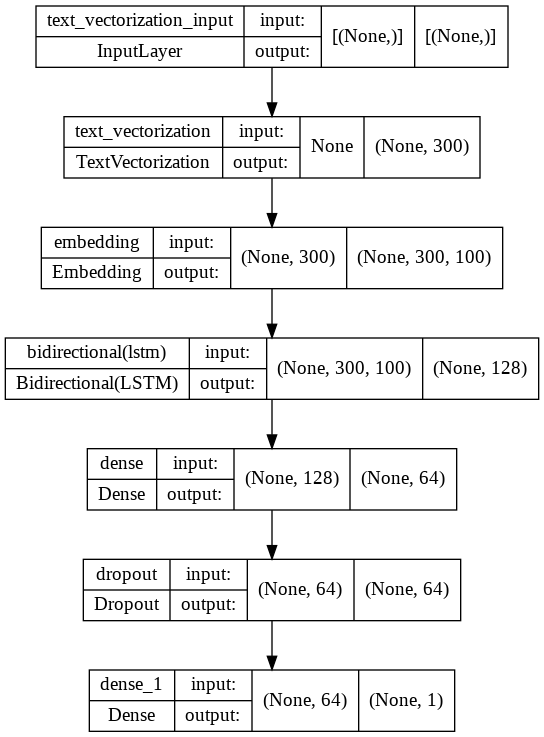

In [16]:
plot_model(model, show_shapes=True)

In [26]:
history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/5
8750/8750 [==============================] - 383s 44ms/step - loss: 0.1742 - accuracy: 0.9345 - val_loss: 0.1466 - val_accuracy: 0.9484
Epoch 2/5
8750/8750 [==============================] - 383s 44ms/step - loss: 0.1606 - accuracy: 0.9401 - val_loss: 0.1314 - val_accuracy: 0.9536
Epoch 3/5
8750/8750 [==============================] - 382s 44ms/step - loss: 0.1467 - accuracy: 0.9461 - val_loss: 0.1196 - val_accuracy: 0.9594
Epoch 4/5
8750/8750 [==============================] - 383s 44ms/step - loss: 0.1371 - accuracy: 0.9500 - val_loss: 0.1246 - val_accuracy: 0.9599
Epoch 5/5
8750/8750 [==============================] - 386s 44ms/step - loss: 0.1300 - accuracy: 0.9527 - val_loss: 0.1158 - val_accuracy: 0.9594


In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

594/594 [==============================] - 14s 23ms/step - loss: 0.1319 - accuracy: 0.9510
Test Loss: 0.13194724917411804
Test Accuracy: 0.9509999752044678


In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

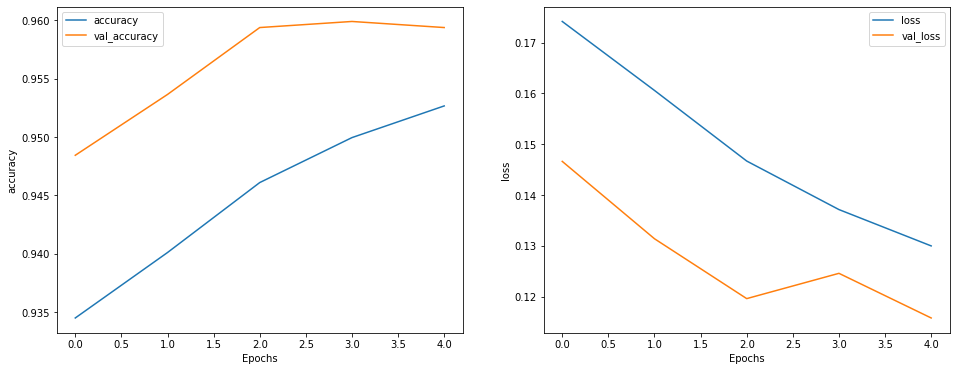

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [35]:
model1 = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
    Bidirectional(tf.keras.layers.LSTM(128,
                                       dropout=DROPOUT_RATE,
                                       return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64,
                                       dropout=DROPOUT_RATE,
                                       return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(32,
                                       dropout=DROPOUT_RATE)),
    Dense(DENSE_HIDDEN_UNITS, activation='relu', 
          kernel_regularizer='l2'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

In [36]:
model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [37]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 256)         234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 300, 128)         164352    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                 

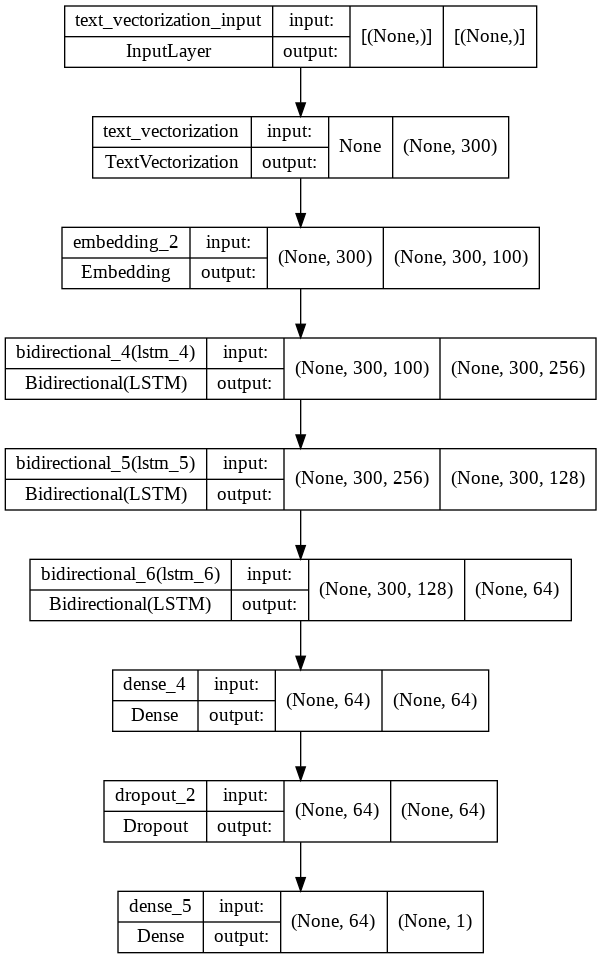

In [38]:
plot_model(model1, show_shapes=True)

In [39]:
history1 = model1.fit(train_dataset, epochs=NUM_EPOCHS,
                      validation_data=test_dataset,
                      validation_steps=VALIDATION_STEPS)

Epoch 1/5
8750/8750 [==============================] - 1035s 116ms/step - loss: 0.2951 - accuracy: 0.9060 - val_loss: 0.1710 - val_accuracy: 0.9344
Epoch 2/5
8750/8750 [==============================] - 1028s 117ms/step - loss: 0.1895 - accuracy: 0.9292 - val_loss: 0.1522 - val_accuracy: 0.9432
Epoch 3/5
8750/8750 [==============================] - 1064s 122ms/step - loss: 0.1717 - accuracy: 0.9358 - val_loss: 0.1344 - val_accuracy: 0.9516
Epoch 4/5
8750/8750 [==============================] - 1073s 123ms/step - loss: 0.1526 - accuracy: 0.9435 - val_loss: 0.1207 - val_accuracy: 0.9583
Epoch 5/5
8750/8750 [==============================] - 1048s 120ms/step - loss: 0.1371 - accuracy: 0.9498 - val_loss: 0.1162 - val_accuracy: 0.9599


In [40]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

594/594 [==============================] - 30s 50ms/step - loss: 0.1323 - accuracy: 0.9504
Test Loss: 0.1323346495628357
Test Accuracy: 0.9503684043884277


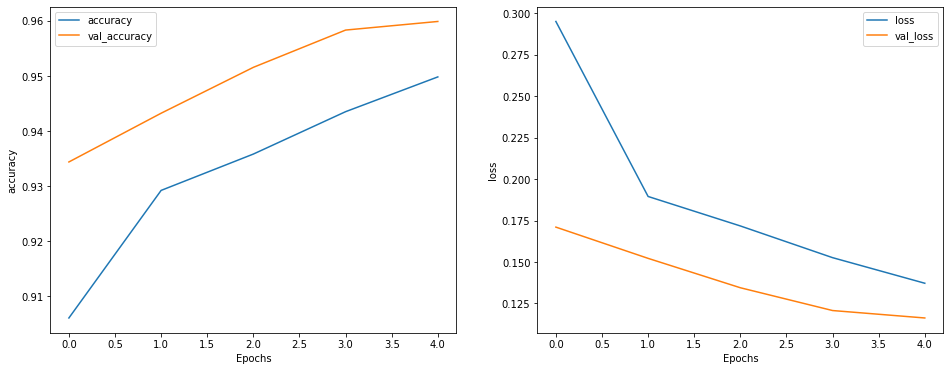

In [41]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')